We start by loading our libraries, reading in the data set as a .csv file, and storing it in a variable called "tennis_data". Instead of using set.seed once at the beginning, we will use it in every code cell that involves randomness so that we can run cells without having to run from the very beginning.

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)

url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "playerstats.csv")
tennis_data <- read_csv("playerstats.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Now we will take a look at he first few rows of our data.

In [2]:
head(tennis_data)

...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Next, we create two new columns named "age" and "best_rank", which contain just the numeric value of the variable, and we filter out any missing values. We then store the result into a variable named "filtered_data".

In [3]:
filtered_data <- select(tennis_data, "Age", "Best Rank") |>
                filter(!is.na(`Age`)) |>
                filter(!is.na(`Best Rank`)) |>
                mutate(age = as.numeric(gsub("\\s*\\(.*\\)", "", Age)),
                       best_rank = as.numeric(gsub("\\s*\\(.*\\)", "",`Best Rank`)))
head(filtered_data)

Age,Best Rank,age,best_rank
<chr>,<chr>,<dbl>,<dbl>
26 (25-04-1993),363 (04-11-2019),26,363
18 (22-12-2001),316 (14-10-2019),18,316
32 (03-11-1987),44 (14-01-2013),32,44
21 (29-05-1998),130 (10-04-2017),21,130
27 (21-10-1992),17 (11-01-2016),27,17
22 (11-02-1997),31 (20-01-2020),22,31


We now select the age and best_rank columns from "filtered_data" that just contain the numeric value, and store them into a variable called "clean_data".

In [4]:
clean_data <- select(filtered_data, "age", "best_rank")
head(clean_data)

age,best_rank
<dbl>,<dbl>
26,363
18,316
32,44
21,130
27,17
22,31


We now do our initial visualizaion to see whether a player's age will be a good predictor for a player's best rank.

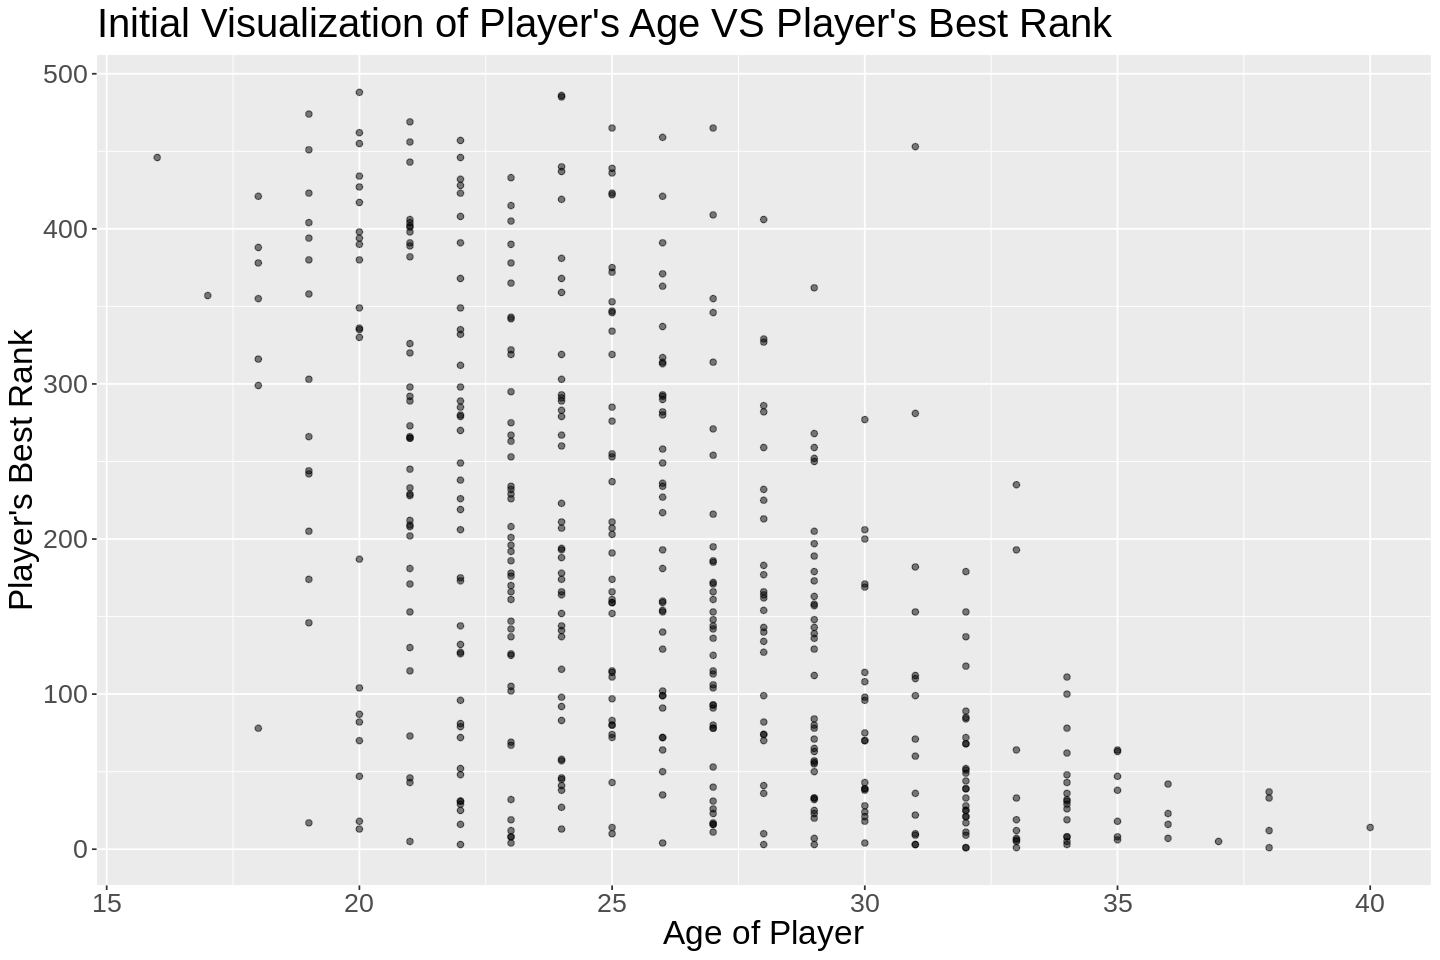

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)

initial_plot <- ggplot(clean_data, aes(x = age, y = best_rank)) +
          geom_point(alpha = 0.5) +
          labs(x = "Age of Player", y = "Player's Best Rank") +
          ggtitle("Initial Visualization of Player's Age VS Player's Best Rank") + 
          theme(text = element_text(size = 20))
initial_plot

We can see that overall, as a player's age increases, their best rank decreases (improves), so we may be able to use a player's age to predict their best rank using knn-regression.

We start our analysis by splitting our data into training and testing sets. 75% of the data will be in our training set, and 25% will be set aside in our testing set to use later. Since the data will be split randomly, we use set.seed for reproducibility.

In [6]:
set.seed(1)

tennis_split <- initial_split(clean_data, prop = 0.75, strata = best_rank)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

We now scale our variables and create our recipe and model specfication.

In [7]:
set.seed(2)

tennis_recipe <- recipe(best_rank ~ age, data = tennis_train) |>
          step_scale(all_predictors()) |>
          step_center(all_predictors())

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("regression")

tennis_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we create the splits for 5-fold cross validation and create our workflow.

In [8]:
set.seed(2)

tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = best_rank)

tennis_workflow <- workflow() |>
      add_recipe(tennis_recipe) |>
      add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We now create our tibble, tune our workflow, and collect the RMSPE and its metrics.

In [9]:
set.seed(3)

gridvals <- tibble(neighbors = seq(1, 100))

tennis_results <- tennis_workflow |>
      tune_grid(resamples = tennis_vfold, grid = gridvals) |>
      collect_metrics() |>
      filter(.metric == "rmse") |>
      arrange(mean) |>
      filter(mean == min(mean))
tennis_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
75,rmse,standard,115.6586,5,2.882583,Preprocessor1_Model075


We now re-train our model using our obtained vale of k=75 and find the RMSE.

In [10]:
set.seed(2)

k_min <- tennis_results |> pull(neighbors)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
      set_engine("kknn") |>
      set_mode("regression")

knn_fit <- workflow() |>
      add_recipe(tennis_recipe) |>
      add_model(knn_spec) |>
      fit(data = tennis_train)

tennis_summary <- knn_fit |>
      predict(tennis_test) |>
      bind_cols(tennis_test) |>
      metrics(truth = best_rank, estimate = .pred) |>
      filter(.metric == 'rmse')
tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,114.4675


We now create our predictions and plot them as a line on our graph.

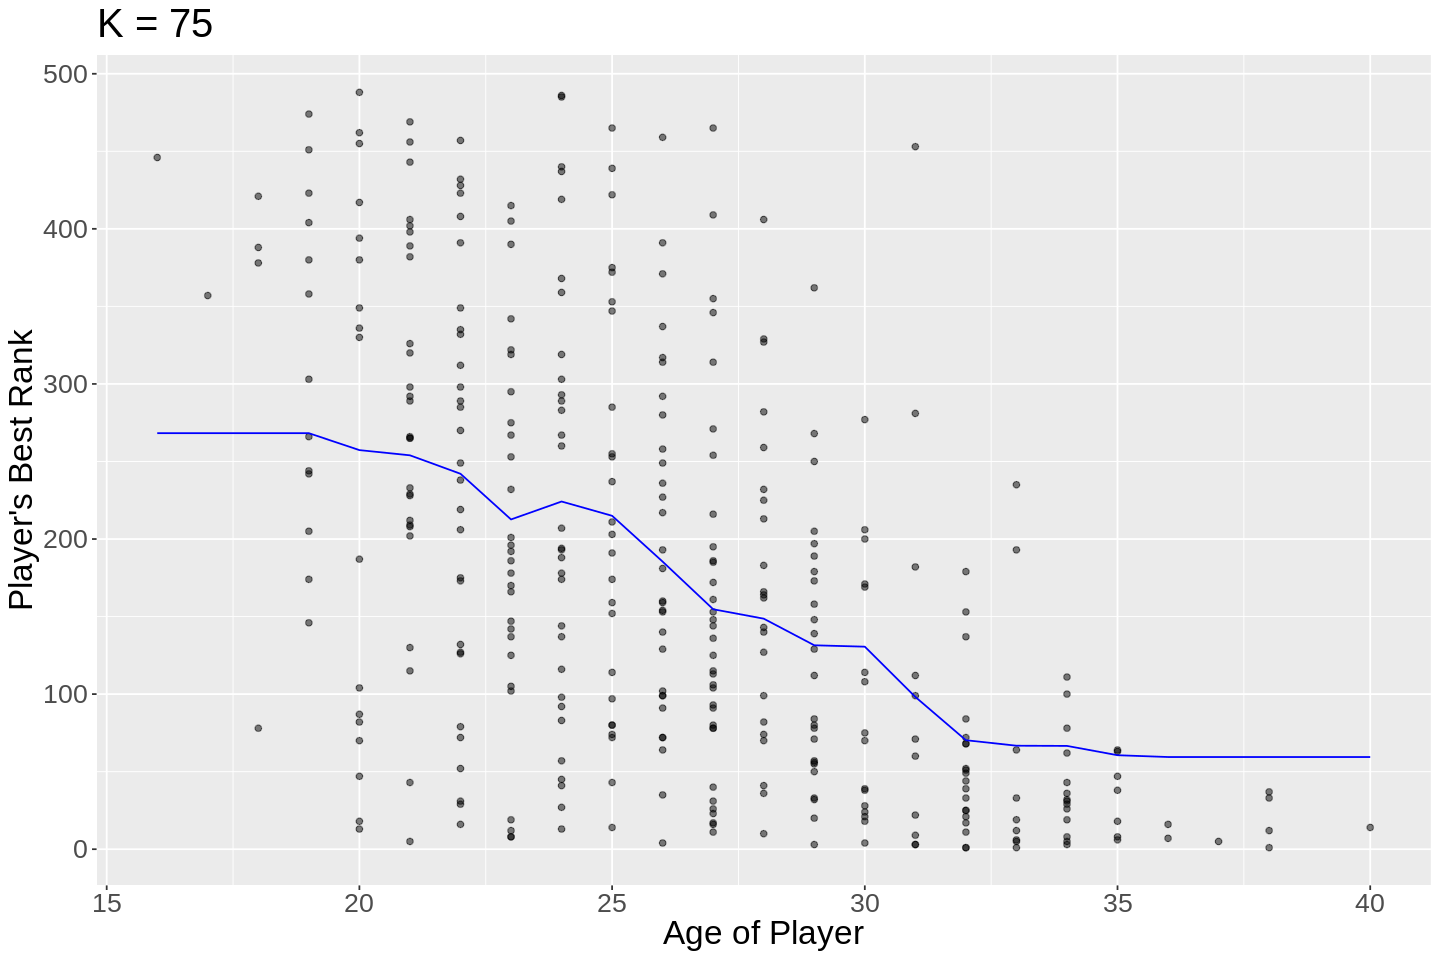

In [11]:
set.seed(3)

tennis_preds <- knn_fit |>
      predict(tennis_train) |>
      bind_cols(tennis_train)

plot_final <- ggplot(tennis_train, aes(x = age, y = best_rank)) +
      geom_point(alpha = 0.5) +
      geom_line(data = tennis_preds, 
                mapping = aes(x = age, y = .pred), 
                color = "blue") +
  xlab("Age of Player") +
  ylab("Player's Best Rank") +
  ggtitle(paste0("K = ", k_min)) + 
  theme(text = element_text(size = 20))
plot_final